In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn

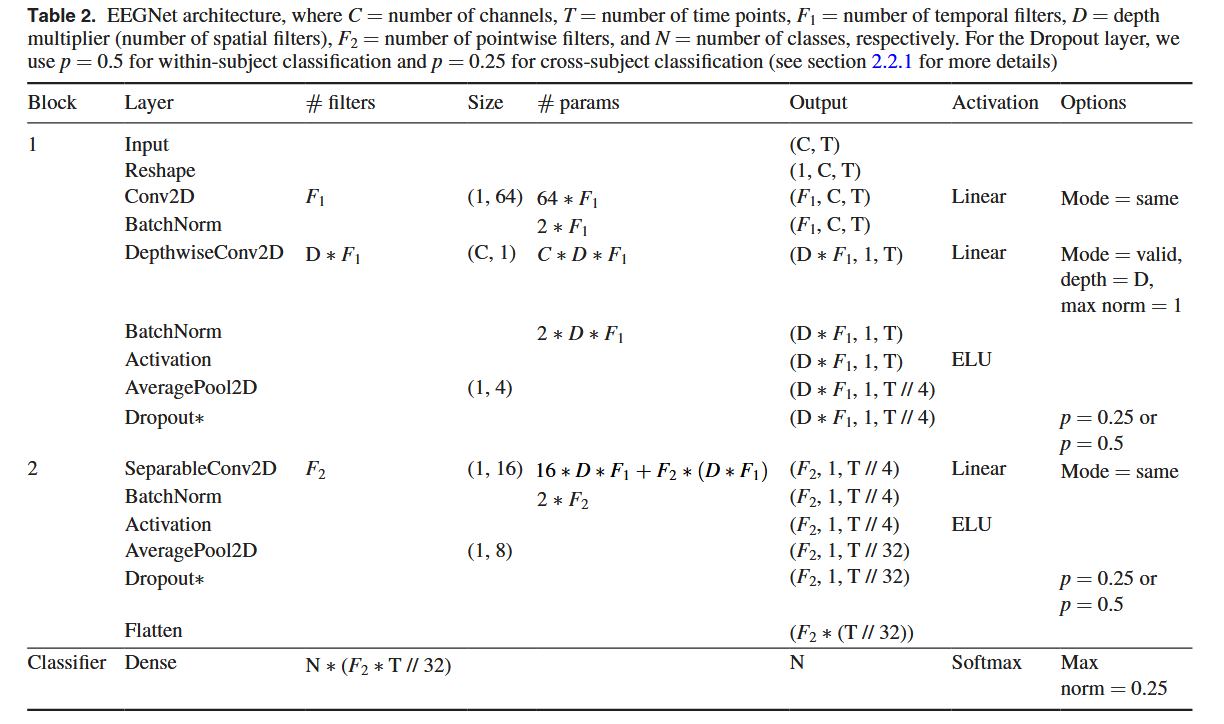

In [ ]:
# EEGNet-8,2 parameters
F1 = 8 # temporal filters
D = 2 # spatial filters
F2 = F1*D # pointwise convolutions, can be any number but authors choose this

In [ ]:
# Define model
class reEEGNet(nn.Module):
    def __init__(self, F1=8, D=2, p=0.5):
        # F1 = temporal filters
        # D = spatial filters
        # p = dropout probability: 0.5 for within-subject classification, 0.25 for cross-subject classification

        super().__init__()
        F2 = F1*D # pointwise convolutions, can be any number but authors choose this
        #self.flatten = nn.Flatten()
        self.temporal = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=F1,
                kernel_size=(1,32),
                padding='same', # keeps initial dims per channel
                groups=1, # default
                bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            # Linear activation = do nothing?
            nn.BatchNorm2d(num_features=F1)) # "We apply batch normalization along the feature map dimension"
        
        self.spatial = nn.Conv2d(
            in_channels=F1,
            out_channels=D*F1,
            kernel_size=(22,1), # C = 22, channels, idk how to refer to input shape here
            padding='valid', # no padding -> collapses channel dimension
            groups=F1, # produces depthwise convolution
            bias=False # "We omit the use of bias units in all convolutional layers."
            )
        # "We also regularize each spatial filter by using a maximum norm constraint of 1 on its weights"
        max_norm_value = 1.0 
        self.spatial.weight.register_hook(lambda x: torch.clamp(x, min=-max_norm_value, max=max_norm_value))

        self.aggregation = nn.Sequential(
            nn.BatchNorm1d(num_features=D*F1), # "We apply batch normalization along the feature map dimension"
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)), # default stride = kernel_size 
            nn.Dropout(p=p)
        )

        self.block_2 = nn.Sequential()
        self.classifier = nn.Sequential(
            nn.Linear(),
            nn.Softmax()
        )

    def forward(self, x):
        #x = self.flatten(x)
        # shape = (n_batches, C, T) -> shape = (n_batches, 1, C, T)
        x = torch.reshape(x,(tuple(np.concatenate(([1],np.array(x.shape)))))) # doesn't account for batch dim, redo
        filter_bank = self.temporal(x)
        spatial_pattern = self.spatial(filter_bank)
        block_1_out = self.aggregation(spatial_pattern)
        block_2_out = self.block_2(block_1_out)
        output = self.classifier(block_2_out)
        
        return output